# Evaluate the performance and relevance of the simple AutoEncoder in detecting some essential structures for predicting similar sequences

This notebook explores if the simple AutoEncoder is able to accurately detect some essential structures and patterns in the TCR sequences. This allows us to evaluate and determine if our simple model can cluster well TCR sequences with similar structures based on TCRdist.

In [2]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sonnia.processing import Processing
from tqdm.notebook import tqdm

# Import necessary modules for pre-processing
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Import necessary modules for model building
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

2023-02-13 15:18:57.144575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load dataset of metaclonotypes
df = pd.read_csv('metaclonotypes_tcrdist_3groups.csv')
df

,CDR3,CDR3_al,tokenized_smiles,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome,v_gene,j_gene,Amino Acids 1,CDR3_al_one_hot,CDR3_al_integer,label,file
0,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD110,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
1,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD126,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
2,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD110,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
3,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD126,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
4,CASSLRTDSYEQYF,CASSL------RTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSLRTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD110,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 10 0 0 0 0 0 0 15 17 3 16 ...,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498,CASSPGGSEQYF,CASSP--------GGSEQYF,"[12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...",CASSPGGSEQYF+TCRBV18-01+TCRBJ02-07,CTGAGGATCCAGCAGGTAGTGCGAGGAGATTCGGCAGCTTATTTCT...,eXL30,ORF1ab,"DTDFVNEFYAY,NRDVDTDFVNEFY",15641,15685,TCRBV18-01,TCRBJ02-07,DTDFVNEFYAY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 13 0 0 0 0 0 0 0 0 6 6 ...,50,2
3499,CASSPGGTGYTF,CASSP--------GGTGYTF,"[12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...",CASSPGGTGYTF+TCRBV18-01+TCRBJ01-02,CTGAGGATCCAGCAGGTAGTGCGAGGAGATTCGGCAGCTTATTTCT...,eEE226,ORF1ab,"DTDFVNEFYAY,NRDVDTDFVNEFY",15641,15685,TCRBV18-01,TCRBJ01-02,DTDFVNEFYAY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 13 0 0 0 0 0 0 0 0 6 6 ...,50,2
3500,CASSPGGQKLFF,CASSP--------GGQKLFF,"[12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...",CASSPGGQKLFF+TCRBV18-01+TCRBJ01-04,CTGAGGATCCAGCAGGTAGTGCGAGGAGATTCGGCAGCTTATTTCT...,eXL30,ORF1ab,"DTDFVNEFYAY,NRDVDTDFVNEFY",15641,15685,TCRBV18-01,TCRBJ01-04,DTDFVNEFYAY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 13 0 0 0 0 0 0 0 0 6 6 ...,50,2
3501,CASSPGGTRLFF,CASSP--------GGTRLFF,"[12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...",CASSPGGTRLFF+TCRBV18-01+TCRBJ01-04,CTGAGGATCCAGCAGGTAGTGCGAGGAGATTCGGCAGCTTATTTCT...,eEE226,ORF1ab,"DTDFVNEFYAY,NRDVDTDFVNEFY",15641,15685,TCRBV18-01,TCRBJ01-04,DTDFVNEFYAY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 13 0 0 0 0 0 0 0 0 6 6 ...,50,2


In [4]:
aa = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q","R", "S", "T", "V", "W", "Y", "-"]
label_encoder = LabelEncoder()
y_encoder =LabelEncoder()
y_encoder = y_encoder.fit(df['Amino Acids'].unique())
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = label_encoder.fit_transform(aa)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit(integer_encoded)


one_hot_status = False
col_one_hot = []
col_integer = []
y_labels = []
for k in tqdm(df.index):
    integer_encoded = label_encoder.transform(list(df.loc[k,"CDR3_al"]))
    col_integer.append(integer_encoded)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    if one_hot_status:
        onehot_encoded = onehot_encoder.transform(integer_encoded)
        col_one_hot.append(onehot_encoded)
    y_label = y_encoder.transform([df.loc[k,"Amino Acids"]])
    y_labels.append(y_label)

y_labels = [int(y) for y in y_labels]
if one_hot_status:
    df["CDR3_al_one_hot"] = col_one_hot
df["CDR3_al_integer"] = col_integer
df["label"] = y_labels

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# Reproduce the model architecture of the simple AutoEncoder model and training the model again
df = df.sample(frac=1).reset_index(drop=True)
values = np.stack(df["CDR3_al_integer"].to_numpy())
X_train = tf.constant(values)
n_inputs = 20
print(len(X_train))
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)
# define bottleneck
n_bottleneck = 2
bottleneck = Dense(n_bottleneck)(e)
# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=1)

2023-02-13 15:19:01.707909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3503
Epoch 1/100
219/219 [==============================] - 1s 1ms/step - loss: 54.0367
Epoch 2/100
219/219 [==============================] - 0s 970us/step - loss: 13.8060
Epoch 3/100
219/219 [==============================] - 0s 949us/step - loss: 4.1266
Epoch 4/100
219/219 [==============================] - 0s 897us/step - loss: 2.5141
Epoch 5/100
219/219 [==============================] - 0s 889us/step - loss: 2.0406
Epoch 6/100
219/219 [==============================] - 0s 878us/step - loss: 1.9302
Epoch 7/100
219/219 [==============================] - 0s 944us/step - loss: 2.0058
Epoch 8/100
219/219 [==============================] - 0s 892us/step - loss: 1.7520
Epoch 9/100
219/219 [==============================] - 0s 875us/step - loss: 1.7104
Epoch 10/100
219/219 [==============================] - 0s 880us/step - loss: 1.6339
Epoch 11/100
219/219 [==============================] - 0s 881us/step - loss: 1.6683
Epoch 12/100
219/219 [==============================] - 0s 879us/step

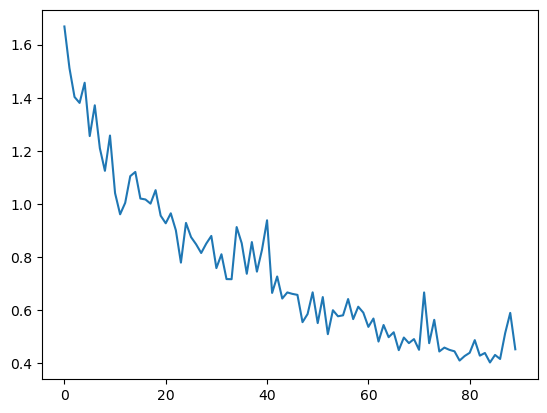

In [9]:
# Plot the training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'][10:], label='train')

In [10]:
# Keep only the encoder part of the model
encoder = Model(inputs=visible, outputs=bottleneck)

7/7 [==============================] - 0s 823us/step


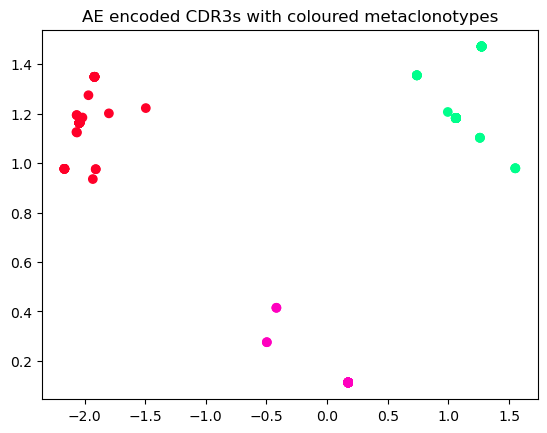

In [11]:
# Plot the latent space with each data point coloured with its metaclonotype group
import seaborn as sns
rgb_values = sns.color_palette("Spectral", df["label"].nunique())
df["label_color"] = df["label"].apply(lambda x: rgb_values[x])
N = 200
X_test = X_train[:N]
X_test_encode = encoder.predict(X_test[:N])
plt.scatter(X_test_encode[:,0], X_test_encode[:,1], c=(df['file'][:N]), cmap='gist_rainbow')
#Plot text labels 
#for i in range(N):
    #plt.text(X_test_encode[i,0], X_test_encode[i,1], df['file'][i], fontsize=9)
plt.title('AE encoded CDR3s with coloured metaclonotypes')
plt.show()

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


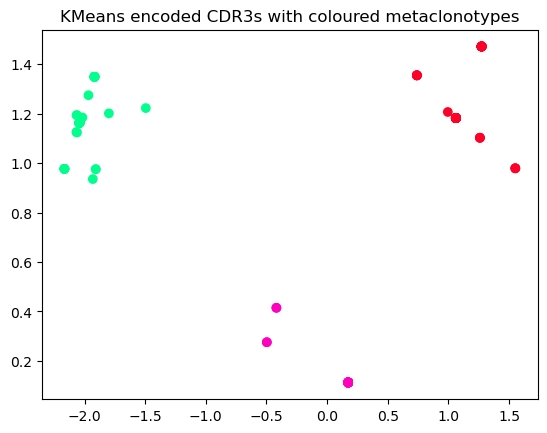

Accuracy:  1.0


In [30]:
# KMeans 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_test_encode)
plt.scatter(X_test_encode[:,0], X_test_encode[:,1], c=kmeans.labels_, cmap='gist_rainbow')
plt.title('KMeans encoded CDR3s with coloured metaclonotypes')
plt.show()
kmeans.labels_ = [1 if x == 0 else 0 if x == 1 else 2 for x in kmeans.labels_]
print("Accuracy: ", np.sum(kmeans.labels_ == df['label'][:N])/N)
